In [1]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch import nn

from statistics import mean

In [2]:
import utils_generic as generic
import rrnn_modelo as rrnn
import model_confs as confs
import singletask_dep as st

import train

from gensim.models import KeyedVectors

c:\Users\kuina\anaconda3\envs\tfg\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

word2vec_path = r"C:\Users\kuina\gensim-data\word2vec-google-news-300\word2vec-google-news-300.gz"
word2vec_model =  KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

encoding_type = 'relative'

# Datos ConvAI2

In [4]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [5]:
convai_train = data['train']
convai_val = data['validation']


vocabulary = set(generic.create_word_to_index(convai_train).keys()) & set(word2vec_model.key_to_index.keys())
word_to_index = {}
emb_weights = []
for new_id, word in zip(range(len(vocabulary)),vocabulary):
    word_to_index[word] = new_id
    emb_weights.append(word2vec_model[word])

emb_weights = np.array(emb_weights)



In [6]:
vocab_dep = st.Vocabulary(data['train'],encoding_type)
convai_train_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_train,['about','to','as'],vocab_dep,word_to_index) 
convai_val_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_val,['about','to','as'],vocab_dep,word_to_index) 

In [7]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_train_token,task,eval=False,deps=True)

In [8]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_val_token,task,eval=False,deps=True)

# Datos md_gender

In [9]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [10]:
md_tokenized = generic.tokenize_dataset_with_dependencies_rrnn(md_data,['about','to','as'],vocab_dep,word_to_index) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = rrnn.DatasetSingleTaskRRNN(md_tokenized,task,eval=True,deps=True)

# Creación dataloaders

In [11]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [12]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [13]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn_dep)

# Prueba hiperparámetros 1

In [14]:
emb_dim = 20
vocab_size = len(word_to_index)
lstm_hidden_dim = 128

## ABOUT

In [15]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6888479999548882 	 Validation loss: 0.6875827716568769 	 
  1%|          | 574/57400 [00:05<08:24, 112.71it/s]
Epoch 2 	 Training loss: 0.6846042504917038 	 Validation loss: 0.6854349667743102 	 
  2%|▏         | 1148/57400 [00:11<08:33, 109.49it/s]
Epoch 3 	 Training loss: 0.6825752007005937 	 Validation loss: 0.6845791238849446 	 
  3%|▎         | 1722/57400 [00:16<08:11, 113.23it/s]
Epoch 4 	 Training loss: 0.6817418132301822 	 Validation loss: 0.6844163910817291 	 
  4%|▍         | 2296/57400 [00:22<08:02, 114.17it/s]
Epoch 5 	 Training loss: 0.6814465947475168 	 Validation loss: 0.684022102315547 	 
  5%|▌         | 2870/57400 [00:27<08:04, 112.59it/s]
Epoch 6 	 Training loss: 0.6812725446157755 	 Validation loss: 0.6842285132004042 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:33<07:52, 114.12it/s]
Epoch 7 	 Training loss: 0.6811761575708821 	 Validation loss: 0.6842722731121516 	 

2 epoch without improvement
  7%|▋         | 4018/574

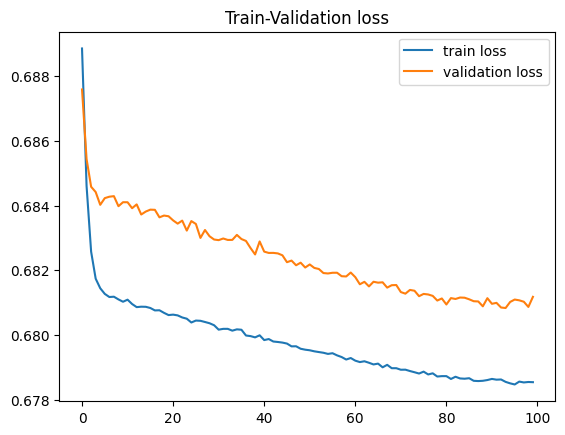

In [16]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_about_w2v_1'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [17]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.4897959183673469, 'precision': 0.4897959183673469, 'f1': 0.4897959183673469, 'accuracy': 0.4897959183673469}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5189393939393939, 'precision': 0.5189393939393939, 'f1': 0.5189393939393939, 'accuracy': 0.5189393939393939}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.516297262059974, 'precision': 0.516297262059974, 'f1': 0.516297262059974, 'accuracy': 0.516297262059974}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 



  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6901757750361639 	 Validation loss: 0.6875757686162399 	 
  1%|          | 574/57400 [00:05<08:25, 112.36it/s]
Epoch 2 	 Training loss: 0.6847915107364854 	 Validation loss: 0.6847884543871475 	 
  2%|▏         | 1148/57400 [00:11<08:15, 113.46it/s]
Epoch 3 	 Training loss: 0.6824322530824548 	 Validation loss: 0.6840140577089988 	 
  3%|▎         | 1722/57400 [00:16<08:22, 110.78it/s]
Epoch 4 	 Training loss: 0.6815547747894447 	 Validation loss: 0.6836157289601988 	 
  4%|▍         | 2296/57400 [00:22<08:11, 112.06it/s]
Epoch 5 	 Training loss: 0.6811792435131007 	 Validation loss: 0.6834005774077723 	 
  5%|▌         | 2870/57400 [00:27<08:12, 110.69it/s]
Epoch 6 	 Training loss: 0.6810528160387631 	 Validation loss: 0.6835632112066624 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:33<08:07, 110.74it/s]
Epoch 7 	 Training loss: 0.6810501122308525 	 Validation loss: 0.6836022966999119 	 

2 epoch without improvement
  7%|▋         | 4018/57

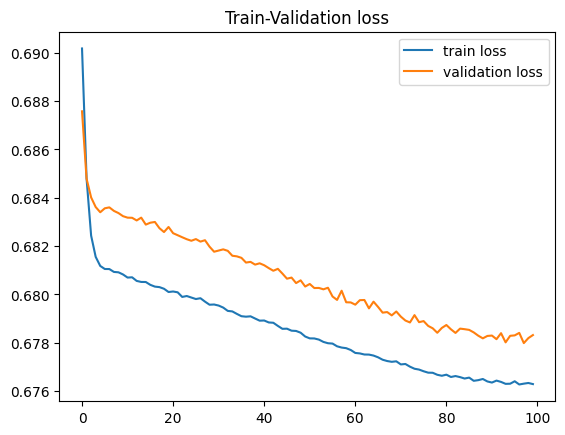

In [18]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_about_w2v_2'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [19]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.4897959183673469, 'precision': 0.4897959183673469, 'f1': 0.4897959183673469, 'accuracy': 0.4897959183673469}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5189393939393939, 'precision': 0.5189393939393939, 'f1': 0.5189393939393939, 'accuracy': 0.5189393939393939}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.516297262059974, 'precision': 0.516297262059974, 'f1': 0.516297262059974, 'accuracy': 0.516297262059974}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 



  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6843483409607451 	 Validation loss: 0.6846738376859891 	 
  1%|          | 574/57400 [00:05<08:37, 109.91it/s]
Epoch 2 	 Training loss: 0.682079047276168 	 Validation loss: 0.683686865588366 	 
  2%|▏         | 1148/57400 [00:11<08:31, 109.91it/s]
Epoch 3 	 Training loss: 0.6812295075700674 	 Validation loss: 0.6836847157801612 	 
  3%|▎         | 1722/57400 [00:16<08:18, 111.67it/s]
Epoch 4 	 Training loss: 0.6810815037335253 	 Validation loss: 0.6836919804750863 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:22<08:12, 111.96it/s]
Epoch 5 	 Training loss: 0.6809197396351485 	 Validation loss: 0.683577705237825 	 
  5%|▌         | 2870/57400 [00:27<08:06, 112.19it/s]
Epoch 6 	 Training loss: 0.6807693865033392 	 Validation loss: 0.6835725772178779 	 
  6%|▌         | 3444/57400 [00:33<08:13, 109.36it/s]
Epoch 7 	 Training loss: 0.6807310741122176 	 Validation loss: 0.6836132700160399 	 

1 epoch without improvement
  7%|▋         | 4018/57400

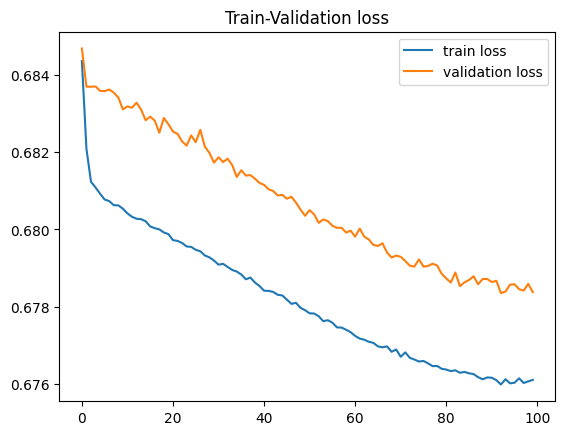

In [20]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_about_w2v_3'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [21]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.4897959183673469, 'precision': 0.4897959183673469, 'f1': 0.4897959183673469, 'accuracy': 0.4897959183673469}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5189393939393939, 'precision': 0.5189393939393939, 'f1': 0.5189393939393939, 'accuracy': 0.5189393939393939}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.516297262059974, 'precision': 0.516297262059974, 'f1': 0.516297262059974, 'accuracy': 0.516297262059974}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 



In [22]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.4897959183673469, 'precision': 0.4897959183673469, 'f1': 0.4897959183673469, 'accuracy': 0.4897959183673469}
Métricas etiqueta male: {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
Métricas etiqueta female:  {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}

 to
Resultado global: {'recall': 0.5189393939393939, 'precision': 0.5189393939393939, 'f1': 0.5189393939393939, 'accuracy': 0.5189393939393939}
Métricas etiqueta male: {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
Métricas etiqueta female:  {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}

 as
Resultado global: {'recall': 0.516297262059974, 'precision': 0.516297262059974, 'f1': 0.516297262059974, 'accuracy': 0.516297262059974}
Métricas etiqueta male: {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
Métricas etiqueta female:  {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}


## TO

In [23]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6934977808272798 	 Validation loss: 0.6938766917939914 	 
  1%|          | 574/57400 [00:06<09:25, 100.44it/s]
Epoch 2 	 Training loss: 0.6932488619658175 	 Validation loss: 0.6935072773593968 	 
  2%|▏         | 1148/57400 [00:12<09:30, 98.62it/s]
Epoch 3 	 Training loss: 0.6931996597853272 	 Validation loss: 0.6932876544483637 	 
  3%|▎         | 1722/57400 [00:18<09:19, 99.56it/s]
Epoch 4 	 Training loss: 0.693170050814592 	 Validation loss: 0.6931273704868252 	 
  4%|▍         | 2296/57400 [00:24<09:07, 100.73it/s]
Epoch 5 	 Training loss: 0.6931863417816494 	 Validation loss: 0.6931236881320759 	 
  5%|▌         | 2870/57400 [00:30<09:02, 100.55it/s]
Epoch 6 	 Training loss: 0.6931566889900779 	 Validation loss: 0.6929084335343313 	 
  6%|▌         | 3444/57400 [00:37<09:02, 99.53it/s]
Epoch 7 	 Training loss: 0.6931955805015896 	 Validation loss: 0.6928602729813528 	 
  7%|▋         | 4018/57400 [00:43<08:57, 99.36it/s]
Epoch 8 	 Training loss: 0.693169

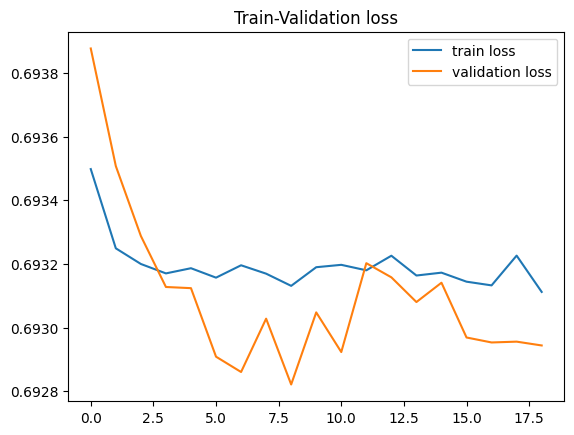

In [24]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_to_w2v_1'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [25]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5, 'precision': 0.5, 'f1': 0.5, 'accuracy': 0.5}
MALE {'recall': 0.10677083333333333, 'precision': 0.10677083333333333, 'f1': 0.10677083333333333, 'accuracy': 0.10677083333333333}
FEMALE {'recall': 0.8775, 'precision': 0.8775, 'f1': 0.8775, 'accuracy': 0.8775} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4861111111111111, 'precision': 0.4861111111111111, 'f1': 0.4861111111111111, 'accuracy': 0.4861111111111111}
MALE {'recall': 0.0851581508515815, 'precision': 0.0851581508515815, 'f1': 0.0851581508515815, 'accuracy': 0.0851581508515815}
FEMALE {'recall': 0.9186351706036745, 'precision': 0.9186351706036745, 'f1': 0.9186351706036745, 'accuracy': 0.9186351706036745} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4784876140808344, 'precision': 0.4784876140808344, 'f1': 0.4784876140808344, 'accuracy': 0.4784876140808344}
MALE {'recall': 0.09090909090909091, 'precision': 0.09090909090909091, '

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6935536160493977 	 Validation loss: 0.6940395286527731 	 
  1%|          | 574/57400 [00:06<09:18, 101.72it/s]
Epoch 2 	 Training loss: 0.6933235304903901 	 Validation loss: 0.6938042792223268 	 
  2%|▏         | 1148/57400 [00:12<09:12, 101.73it/s]
Epoch 3 	 Training loss: 0.6932277680481768 	 Validation loss: 0.6933113225435806 	 
  3%|▎         | 1722/57400 [00:18<09:15, 100.29it/s]
Epoch 4 	 Training loss: 0.6931703866358834 	 Validation loss: 0.6932109382192967 	 
  4%|▍         | 2296/57400 [00:24<09:05, 100.93it/s]
Epoch 5 	 Training loss: 0.6931808520277203 	 Validation loss: 0.6930244989314321 	 
  5%|▌         | 2870/57400 [00:30<09:15, 98.22it/s]
Epoch 6 	 Training loss: 0.6931564712358269 	 Validation loss: 0.6928333821943251 	 
  6%|▌         | 3444/57400 [00:36<09:04, 99.14it/s]
Epoch 7 	 Training loss: 0.6932053156846076 	 Validation loss: 0.693142719187979 	 

1 epoch without improvement
  7%|▋         | 4018/57400 [00:43<09:06, 97.64it/s]
Epo

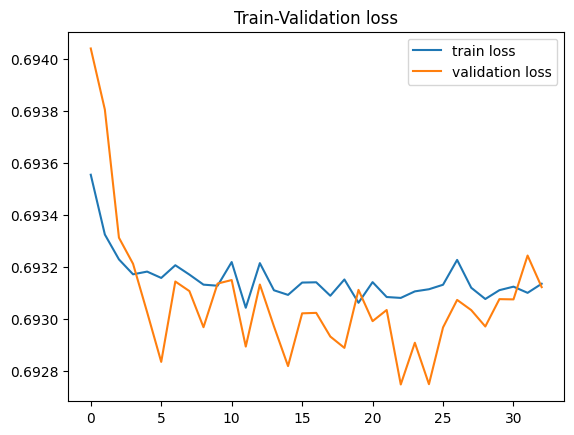

In [26]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_to_w2v_2'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [27]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5, 'precision': 0.5, 'f1': 0.5, 'accuracy': 0.5}
MALE {'recall': 0.1875, 'precision': 0.1875, 'f1': 0.1875, 'accuracy': 0.1875}
FEMALE {'recall': 0.8, 'precision': 0.8, 'f1': 0.8000000000000002, 'accuracy': 0.8} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.494949494949495, 'precision': 0.494949494949495, 'f1': 0.494949494949495, 'accuracy': 0.494949494949495}
MALE {'recall': 0.21654501216545013, 'precision': 0.21654501216545013, 'f1': 0.21654501216545013, 'accuracy': 0.21654501216545013}
FEMALE {'recall': 0.7952755905511811, 'precision': 0.7952755905511811, 'f1': 0.7952755905511811, 'accuracy': 0.7952755905511811} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5071707953063885, 'precision': 0.5071707953063885, 'f1': 0.5071707953063885, 'accuracy': 0.5071707953063885}
MALE {'recall': 0.22474747474747475, 'precision': 0.22474747474747475, 'f1': 0.22474747474747475, 'accuracy': 0.224747474

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.693172425031662 	 Validation loss: 0.692715804455644 	 
  1%|          | 574/57400 [00:06<09:27, 100.14it/s]
Epoch 2 	 Training loss: 0.6932364773874914 	 Validation loss: 0.6924089445906171 	 
  2%|▏         | 1148/57400 [00:12<09:12, 101.77it/s]
Epoch 3 	 Training loss: 0.6932491583275878 	 Validation loss: 0.6928344116372577 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:18<09:12, 100.69it/s]
Epoch 4 	 Training loss: 0.6932369435290426 	 Validation loss: 0.6929348050537756 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [00:24<09:06, 100.83it/s]
Epoch 5 	 Training loss: 0.693150251792283 	 Validation loss: 0.6926868204343117 	 

3 epoch without improvement
  5%|▌         | 2870/57400 [00:30<08:58, 101.18it/s]
Epoch 6 	 Training loss: 0.6932036891216184 	 Validation loss: 0.6926170112723011 	 

4 epoch without improvement
  6%|▌         | 3444/57400 [00:36<08:50, 101.61it/s]
Epoch 7 	 Training loss: 0.6931880153845411 	 Validati

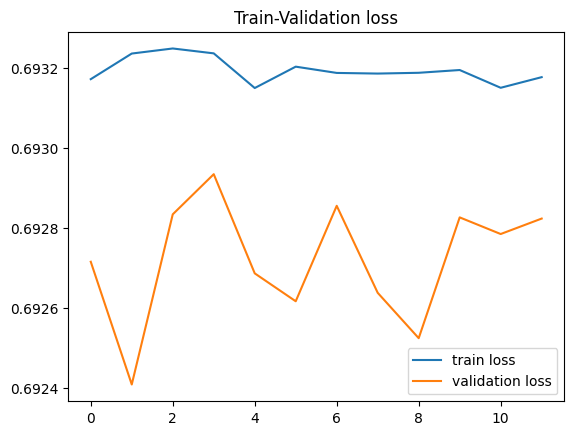

In [28]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_to_w2v_3'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [29]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5063775510204082, 'precision': 0.5063775510204082, 'f1': 0.5063775510204082, 'accuracy': 0.5063775510204082}
MALE {'recall': 0.09895833333333333, 'precision': 0.09895833333333333, 'f1': 0.09895833333333333, 'accuracy': 0.09895833333333333}
FEMALE {'recall': 0.8975, 'precision': 0.8975, 'f1': 0.8975, 'accuracy': 0.8975} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.476010101010101, 'precision': 0.476010101010101, 'f1': 0.476010101010101, 'accuracy': 0.476010101010101}
MALE {'recall': 0.0851581508515815, 'precision': 0.0851581508515815, 'f1': 0.0851581508515815, 'accuracy': 0.0851581508515815}
FEMALE {'recall': 0.8976377952755905, 'precision': 0.8976377952755905, 'f1': 0.8976377952755905, 'accuracy': 0.8976377952755905} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.49674054758800523, 'precision': 0.49674054758800523, 'f1': 0.49674054758800523, 'accuracy': 0.49674054758800523}
MALE {'recal

In [30]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.502125850340136, 'precision': 0.502125850340136, 'f1': 0.502125850340136, 'accuracy': 0.502125850340136}
Métricas etiqueta male: {'recall': 0.1310763888888889, 'precision': 0.1310763888888889, 'f1': 0.1310763888888889, 'accuracy': 0.1310763888888889}
Métricas etiqueta female:  {'recall': 0.8583333333333333, 'precision': 0.8583333333333333, 'f1': 0.8583333333333334, 'accuracy': 0.8583333333333333}

 to
Resultado global: {'recall': 0.48569023569023567, 'precision': 0.48569023569023567, 'f1': 0.48569023569023567, 'accuracy': 0.48569023569023567}
Métricas etiqueta male: {'recall': 0.12895377128953772, 'precision': 0.12895377128953772, 'f1': 0.12895377128953772, 'accuracy': 0.12895377128953772}
Métricas etiqueta female:  {'recall': 0.8705161854768154, 'precision': 0.8705161854768154, 'f1': 0.8705161854768154, 'accuracy': 0.8705161854768154}

 as
Resultado global: {'recall': 0.4941329856584094, 'precision': 0.4941329856584094, 'f1':

# AS

In [31]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6940130335944039 	 Validation loss: 0.6920966334262136 	 
  1%|          | 574/57400 [00:06<09:42, 97.58it/s]
Epoch 2 	 Training loss: 0.6934843720667038 	 Validation loss: 0.6922430274850231 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:12<09:11, 102.04it/s]
Epoch 3 	 Training loss: 0.6933499922528085 	 Validation loss: 0.6928001692739584 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:18<09:15, 100.20it/s]
Epoch 4 	 Training loss: 0.6932173017217722 	 Validation loss: 0.6926695926714752 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:24<09:15, 99.17it/s]
Epoch 5 	 Training loss: 0.6931793757224333 	 Validation loss: 0.6928324376122427 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:30<09:11, 98.94it/s]
Epoch 6 	 Training loss: 0.6931764683864673 	 Validation loss: 0.692605332802918 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [00:36<08:54, 100.91it/s]
Epoch 7 	 Training loss: 0

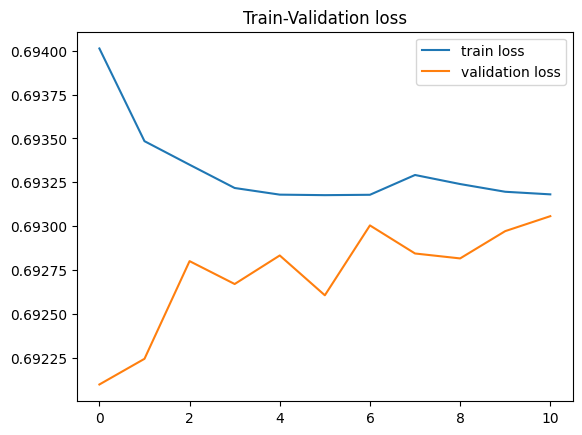

In [32]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_as_w2v_1'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [33]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.514030612244898, 'precision': 0.514030612244898, 'f1': 0.514030612244898, 'accuracy': 0.514030612244898}
MALE {'recall': 0.013020833333333334, 'precision': 0.013020833333333334, 'f1': 0.013020833333333334, 'accuracy': 0.013020833333333334}
FEMALE {'recall': 0.995, 'precision': 0.995, 'f1': 0.995, 'accuracy': 0.995} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4797979797979798, 'precision': 0.4797979797979798, 'f1': 0.4797979797979798, 'accuracy': 0.4797979797979798}
MALE {'recall': 0.0072992700729927005, 'precision': 0.0072992700729927005, 'f1': 0.0072992700729927005, 'accuracy': 0.0072992700729927005}
FEMALE {'recall': 0.989501312335958, 'precision': 0.989501312335958, 'f1': 0.989501312335958, 'accuracy': 0.989501312335958} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4771838331160365, 'precision': 0.4771838331160365, 'f1': 0.4771838331160365, 'accuracy': 0.4771838331160365}
MALE {'r

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6935669323916219 	 Validation loss: 0.6942105717578176 	 
  1%|          | 574/57400 [00:06<09:22, 101.04it/s]
Epoch 2 	 Training loss: 0.6933208786029018 	 Validation loss: 0.6934613706701893 	 
  2%|▏         | 1148/57400 [00:12<09:15, 101.32it/s]
Epoch 3 	 Training loss: 0.6931946642099772 	 Validation loss: 0.6932820000890958 	 
  3%|▎         | 1722/57400 [00:19<09:08, 101.43it/s]
Epoch 4 	 Training loss: 0.693229765322981 	 Validation loss: 0.6931178741535898 	 
  4%|▍         | 2296/57400 [00:25<08:59, 102.14it/s]
Epoch 5 	 Training loss: 0.6932201027247133 	 Validation loss: 0.692911194542707 	 
  5%|▌         | 2870/57400 [00:31<08:58, 101.23it/s]
Epoch 6 	 Training loss: 0.6932063345709745 	 Validation loss: 0.6930361895237939 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:37<08:58, 100.17it/s]
Epoch 7 	 Training loss: 0.6932531487235625 	 Validation loss: 0.6931729316711426 	 

2 epoch without improvement
  7%|▋         | 4018/5740

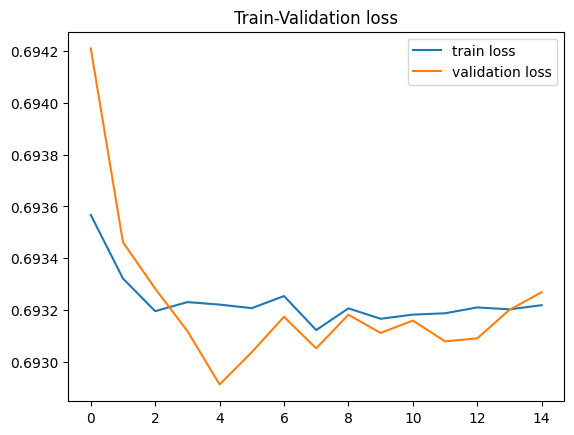

In [34]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_as_w2v_2'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [35]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.475765306122449, 'precision': 0.475765306122449, 'f1': 0.475765306122449, 'accuracy': 0.475765306122449}
MALE {'recall': 0.3541666666666667, 'precision': 0.3541666666666667, 'f1': 0.3541666666666667, 'accuracy': 0.3541666666666667}
FEMALE {'recall': 0.5925, 'precision': 0.5925, 'f1': 0.5925, 'accuracy': 0.5925} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4823232323232323, 'precision': 0.4823232323232323, 'f1': 0.4823232323232323, 'accuracy': 0.4823232323232323}
MALE {'recall': 0.3722627737226277, 'precision': 0.3722627737226277, 'f1': 0.3722627737226277, 'accuracy': 0.3722627737226277}
FEMALE {'recall': 0.6010498687664042, 'precision': 0.6010498687664042, 'f1': 0.6010498687664042, 'accuracy': 0.6010498687664042} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5149934810951761, 'precision': 0.5149934810951761, 'f1': 0.5149934810951761, 'accuracy': 0.5149934810951761}
MALE {'recall': 0.41

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6931793091604519 	 Validation loss: 0.6933589244292955 	 
  1%|          | 574/57400 [00:06<09:32, 99.25it/s]
Epoch 2 	 Training loss: 0.693213568331888 	 Validation loss: 0.6932602928856672 	 
  2%|▏         | 1148/57400 [00:12<09:21, 100.15it/s]
Epoch 3 	 Training loss: 0.6932059241919567 	 Validation loss: 0.692963579953727 	 
  3%|▎         | 1722/57400 [00:18<09:10, 101.16it/s]
Epoch 4 	 Training loss: 0.6932094091945409 	 Validation loss: 0.6932435561034639 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:24<09:10, 100.18it/s]
Epoch 5 	 Training loss: 0.6931553370861226 	 Validation loss: 0.6930540113125817 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [00:30<08:59, 101.06it/s]
Epoch 6 	 Training loss: 0.6931761371341731 	 Validation loss: 0.692794228004197 	 
  6%|▌         | 3444/57400 [00:37<08:51, 101.48it/s]
Epoch 7 	 Training loss: 0.6932463223302822 	 Validation loss: 0.6928523809222852 	 

1 epoch without improvement

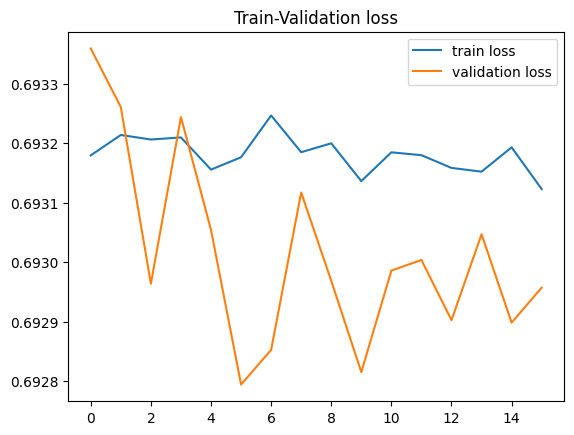

In [36]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_as_w2v_3'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [37]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5369897959183674, 'precision': 0.5369897959183674, 'f1': 0.5369897959183674, 'accuracy': 0.5369897959183674}
MALE {'recall': 0.3489583333333333, 'precision': 0.3489583333333333, 'f1': 0.3489583333333333, 'accuracy': 0.3489583333333333}
FEMALE {'recall': 0.7175, 'precision': 0.7175, 'f1': 0.7175, 'accuracy': 0.7175} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5113636363636364, 'precision': 0.5113636363636364, 'f1': 0.5113636363636364, 'accuracy': 0.5113636363636364}
MALE {'recall': 0.36496350364963503, 'precision': 0.36496350364963503, 'f1': 0.364963503649635, 'accuracy': 0.36496350364963503}
FEMALE {'recall': 0.6692913385826772, 'precision': 0.6692913385826772, 'f1': 0.6692913385826772, 'accuracy': 0.6692913385826772} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.48891786179921776, 'precision': 0.48891786179921776, 'f1': 0.48891786179921776, 'accuracy': 0.48891786179921776}
MALE {'rec

In [38]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.5089285714285714, 'precision': 0.5089285714285714, 'f1': 0.5089285714285714, 'accuracy': 0.5089285714285714}
Métricas etiqueta male: {'recall': 0.2387152777777778, 'precision': 0.2387152777777778, 'f1': 0.2387152777777778, 'accuracy': 0.2387152777777778}
Métricas etiqueta female:  {'recall': 0.7683333333333333, 'precision': 0.7683333333333333, 'f1': 0.7683333333333333, 'accuracy': 0.7683333333333333}

 to
Resultado global: {'recall': 0.49116161616161613, 'precision': 0.49116161616161613, 'f1': 0.49116161616161613, 'accuracy': 0.49116161616161613}
Métricas etiqueta male: {'recall': 0.24817518248175183, 'precision': 0.24817518248175183, 'f1': 0.2481751824817518, 'accuracy': 0.24817518248175183}
Métricas etiqueta female:  {'recall': 0.7532808398950132, 'precision': 0.7532808398950132, 'f1': 0.7532808398950132, 'accuracy': 0.7532808398950132}

 as
Resultado global: {'recall': 0.49369839200347676, 'precision': 0.49369839200347676, 